In [1]:
import pandas as pd
import pandas_ta as ta

In [2]:
df = pd.read_csv('../BTCUSDT_1min.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)
df.head()

,Open,High,Low,Close,Volume
timestamp,,,,,
2019-09-16 00:00:00,10302.00,10304.58,10301.84,10304.58,6.352
2019-09-16 00:01:00,10304.58,10306.22,10304.58,10305.94,16.079
2019-09-16 00:02:00,10303.32,10303.63,10300.36,10301.55,13.122
2019-09-16 00:03:00,10303.29,10303.29,10300.36,10302.50,14.395
2019-09-16 00:04:00,10302.42,10304.04,10301.19,10304.04,12.803


In [3]:
df = df.resample('4h').agg({ 'Open': 'first','High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum' })

In [4]:
df.head()

,Open,High,Low,Close,Volume
timestamp,,,,,
2019-09-16 00:00:00,10302.00,10353.81,10300.00,10300.07,3490.788
2019-09-16 04:00:00,10300.24,10325.00,10279.69,10302.30,3131.662
2019-09-16 08:00:00,10301.95,10316.71,10275.74,10282.74,3112.623
2019-09-16 12:00:00,10282.03,10282.03,10115.00,10120.07,3548.878
2019-09-16 16:00:00,10117.40,10160.39,10080.70,10124.17,3419.057


In [5]:
df['ma20'] = ta.sma(df['Close'], length=20)
df['ma30'] = ta.sma(df['Close'], length=30)
df['ma60'] = ta.sma(df['Close'], length=60)
df['ma120'] = ta.sma(df['Close'], length=120)
df['ma200'] = ta.sma(df['Close'], length=200)


In [6]:
import pandas as pd
import numpy as np
# Initialize first position
df['position'] = 0

# Iterate through rows using iterrows
for idx, row in df.iterrows():
    if idx == df.index[0]:  # Skip first timestamp
        continue
        
    prev_idx = df.index[df.index.get_loc(idx) - 1]  # Get previous timestamp
    
    # Copy previous position as default
    df.at[idx, 'position'] = df.at[prev_idx, 'position']
    
    # Long entry
    if (row['ma20'] > row['ma200']) and (df.at[prev_idx, 'position'] == 0):
        df.at[idx, 'position'] = 1
    
    # Long exit
    elif (row['Close'] < row['ma200']) and (df.at[prev_idx, 'position'] == 1):
        df.at[idx, 'position'] = 0
    
    # Short entry
    elif (row['ma20'] < row['ma30']) and (row['ma30'] < row['ma60']) and \
         (row['ma60'] < row['ma120']) and (row['ma120'] < row['ma200']) and \
         (df.at[prev_idx, 'position'] == 0):
        df.at[idx, 'position'] = -1
    
    # Short exit
    elif (row['Close'] > row['ma60']) and (df.at[prev_idx, 'position'] == -1):
        df.at[idx, 'position'] = 0



In [7]:
df['position'].value_counts()

position
 1    5461
 0    3738
-1    1673
Name: count, dtype: int64

In [8]:
df['returns'] = df['Close'].pct_change()
df['strategy_returns'] = df['position'].shift(1) * df['returns']


In [9]:
df['cumulative_returns'] = (1 + df['returns']).cumprod() - 1
df['cumulative_strategy_returns'] = (1 + df['strategy_returns']).cumprod() - 1

In [10]:
# Calculate total return
total_return = df['cumulative_strategy_returns'].iloc[-1]

# Calculate annualized return
# Assuming df index is a datetime index
days = (df.index[-1] - df.index[0]).days
annualized_return = (1 + total_return) ** (365 / days) - 1

# Calculate Sharpe ratio(calculation may not be correct)
sharpe_ratio = df['strategy_returns'].mean() / df['strategy_returns'].std() * np.sqrt(df['strategy_returns'].count())
# Print results
print(f"Total Return: {total_return:.2%}")
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

# O

Total Return: 319.16%
Annualized Return: 33.49%
Sharpe Ratio: 1.79


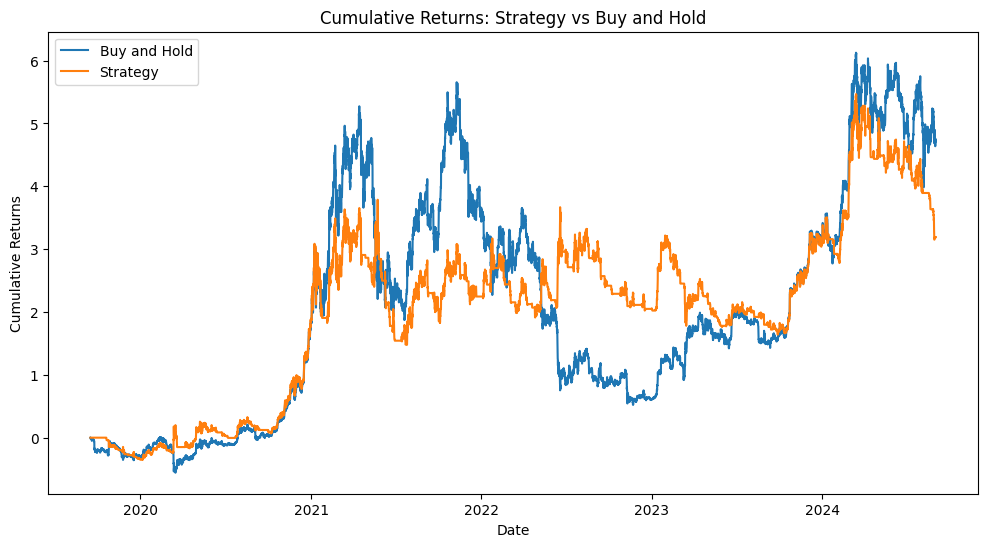

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['cumulative_returns'], label='Buy and Hold')
plt.plot(df.index, df['cumulative_strategy_returns'], label='Strategy')
plt.title('Cumulative Returns: Strategy vs Buy and Hold')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

In [12]:
def load_funding_rate():
    df_funding_rate = pd.read_csv('..\BTCUSDT_funding_rate.csv')
    df_funding_rate['timestamp'] = pd.to_datetime(df_funding_rate['timestamp'], unit='ms')
    df_funding_rate['timestamp'] = df_funding_rate['timestamp'].dt.round('H')
    df_funding_rate.set_index('timestamp', inplace=True)
    return df_funding_rate

df_funding_rate = load_funding_rate()

In [13]:
df = df[['Open','Close','position']]
df['position'] = df['position'].astype(int)
df = df.join(df_funding_rate, how='left')
df['position_change'] = df['position'].diff()

In [14]:
taker_fee = 0.0500 / 100
maker_fee = 0.0200 / 100

def calculate_costs(df,taker_fee, maker_fee):
    df['position_change'] = df['position'].diff()
    
    df.loc[df['position_change'] == 1, 'trade_cost'] = df['Close'] * taker_fee
    df.loc[df['position_change'] == -1, 'trade_cost'] = df['Close'] * maker_fee
    
    df.loc[(df['position'] > 0) & (df['fundingRate'].notnull()), 'funding_cost'] = df['Open'] * df['fundingRate'] * abs(df['position'])
    df.loc[(df['position'] < 0) & (df['fundingRate'].notnull()), 'funding_cost'] = -(df['Open'] * df['fundingRate']) * abs(df['position'])
    
    df['trade_cost'] = df['trade_cost'].fillna(0)
    df['funding_cost'] = df['funding_cost'].fillna(0)
    df['total_cost'] = df['trade_cost'] + df['funding_cost']
    df['total_cost'] = df['total_cost'].fillna(0)
    return df

df = calculate_costs(df, taker_fee, maker_fee)

In [15]:
df.tail()

,Open,Close,position,fundingRate,position_change,trade_cost,funding_cost,total_cost
timestamp,,,,,,,,
2024-08-31 04:00:00,59200.0,59060.8,0,NaN,0.0,0.0,0.0,0.0
2024-08-31 08:00:00,59060.8,59093.1,0,0.000036,0.0,0.0,0.0,0.0
2024-08-31 12:00:00,59093.1,58983.7,0,NaN,0.0,0.0,0.0,0.0
2024-08-31 16:00:00,58983.8,58834.2,0,0.000038,0.0,0.0,0.0,0.0
2024-08-31 20:00:00,58834.3,58941.9,0,NaN,0.0,0.0,0.0,0.0


In [16]:
df['total_cost'].sum()

28843.7373716414

In [17]:
df['trade_cost'].sum()

8972.924158

In [18]:
df['funding_cost'].sum()

19870.8132136414

In [19]:
df[df['trade_cost'] != 0].shape[0]

814

In [20]:
# Buy and hold funding cost
df.loc[df['fundingRate'].notnull(), 'bnh_funding_cost'] = df['Open'] * df['fundingRate']

In [21]:
df['bnh_funding_cost'] = df['bnh_funding_cost'].fillna(0)
df['bnh_funding_cost'].sum()

26819.0328436586